In [ ]:
# Name: Sanjina Shrestha
# ID: 0369929

In [1]:
! pip install pyspark

In [7]:
# Step 1: Importing all the necessary libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from joblib import Parallel, delayed
import multiprocessing
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression as SparkLR, RandomForestRegressor as SparkRF
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import time
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Step 2: Loading and inspecting the dataset
df = pd.read_csv("C:/Users/Acer/Desktop/flood.csv")
print("Data shape:", df.shape)
print("First 5 rows:")
print(df.head())

Data shape: (50000, 21)
First 5 rows:
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5              8            5          2                      7   

   Encroachments  ...  D

In [11]:
print("Data info:")
print(df.info())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  Coastal

In [13]:
print("Descriptive statistics:")
print(df.describe())

Descriptive statistics:
       MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
count      50000.000000        50000.000000      50000.00000   50000.000000   
mean           4.991480            4.984100          5.01594       5.008480   
std            2.236834            2.246488          2.23131       2.222743   
min            0.000000            0.000000          0.00000       0.000000   
25%            3.000000            3.000000          3.00000       3.000000   
50%            5.000000            5.000000          5.00000       5.000000   
75%            6.000000            6.000000          6.00000       6.000000   
max           16.000000           18.000000         16.00000      17.000000   

       Urbanization  ClimateChange  DamsQuality     Siltation  \
count  50000.000000   50000.000000  50000.00000  50000.000000   
mean       4.989060       4.988340      5.01536      4.988600   
std        2.243159       2.226761      2.24500      2.232642   
min 

In [15]:
# Step 3: Data Preprocessing
# Checking for any missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handling duplicates
print("Number of duplicates before handling:", df.duplicated().sum())
df = df.drop_duplicates(keep='first')
print("Number of duplicates after handling:", df.duplicated().sum())

# Handling outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
for col in df.columns:
    if col != 'FloodProbability':
        upper_limit = Q3[col] + 1.5 * IQR[col]
        lower_limit = Q1[col] - 1.5 * IQR[col]
        df[col] = np.where(df[col] > upper_limit, upper_limit, 
                          np.where(df[col] < lower_limit, lower_limit, df[col]))

# Feature Scaling
X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Missing values per column:
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64
Number of duplicates before handling: 0
Number of duplicates after handling: 0


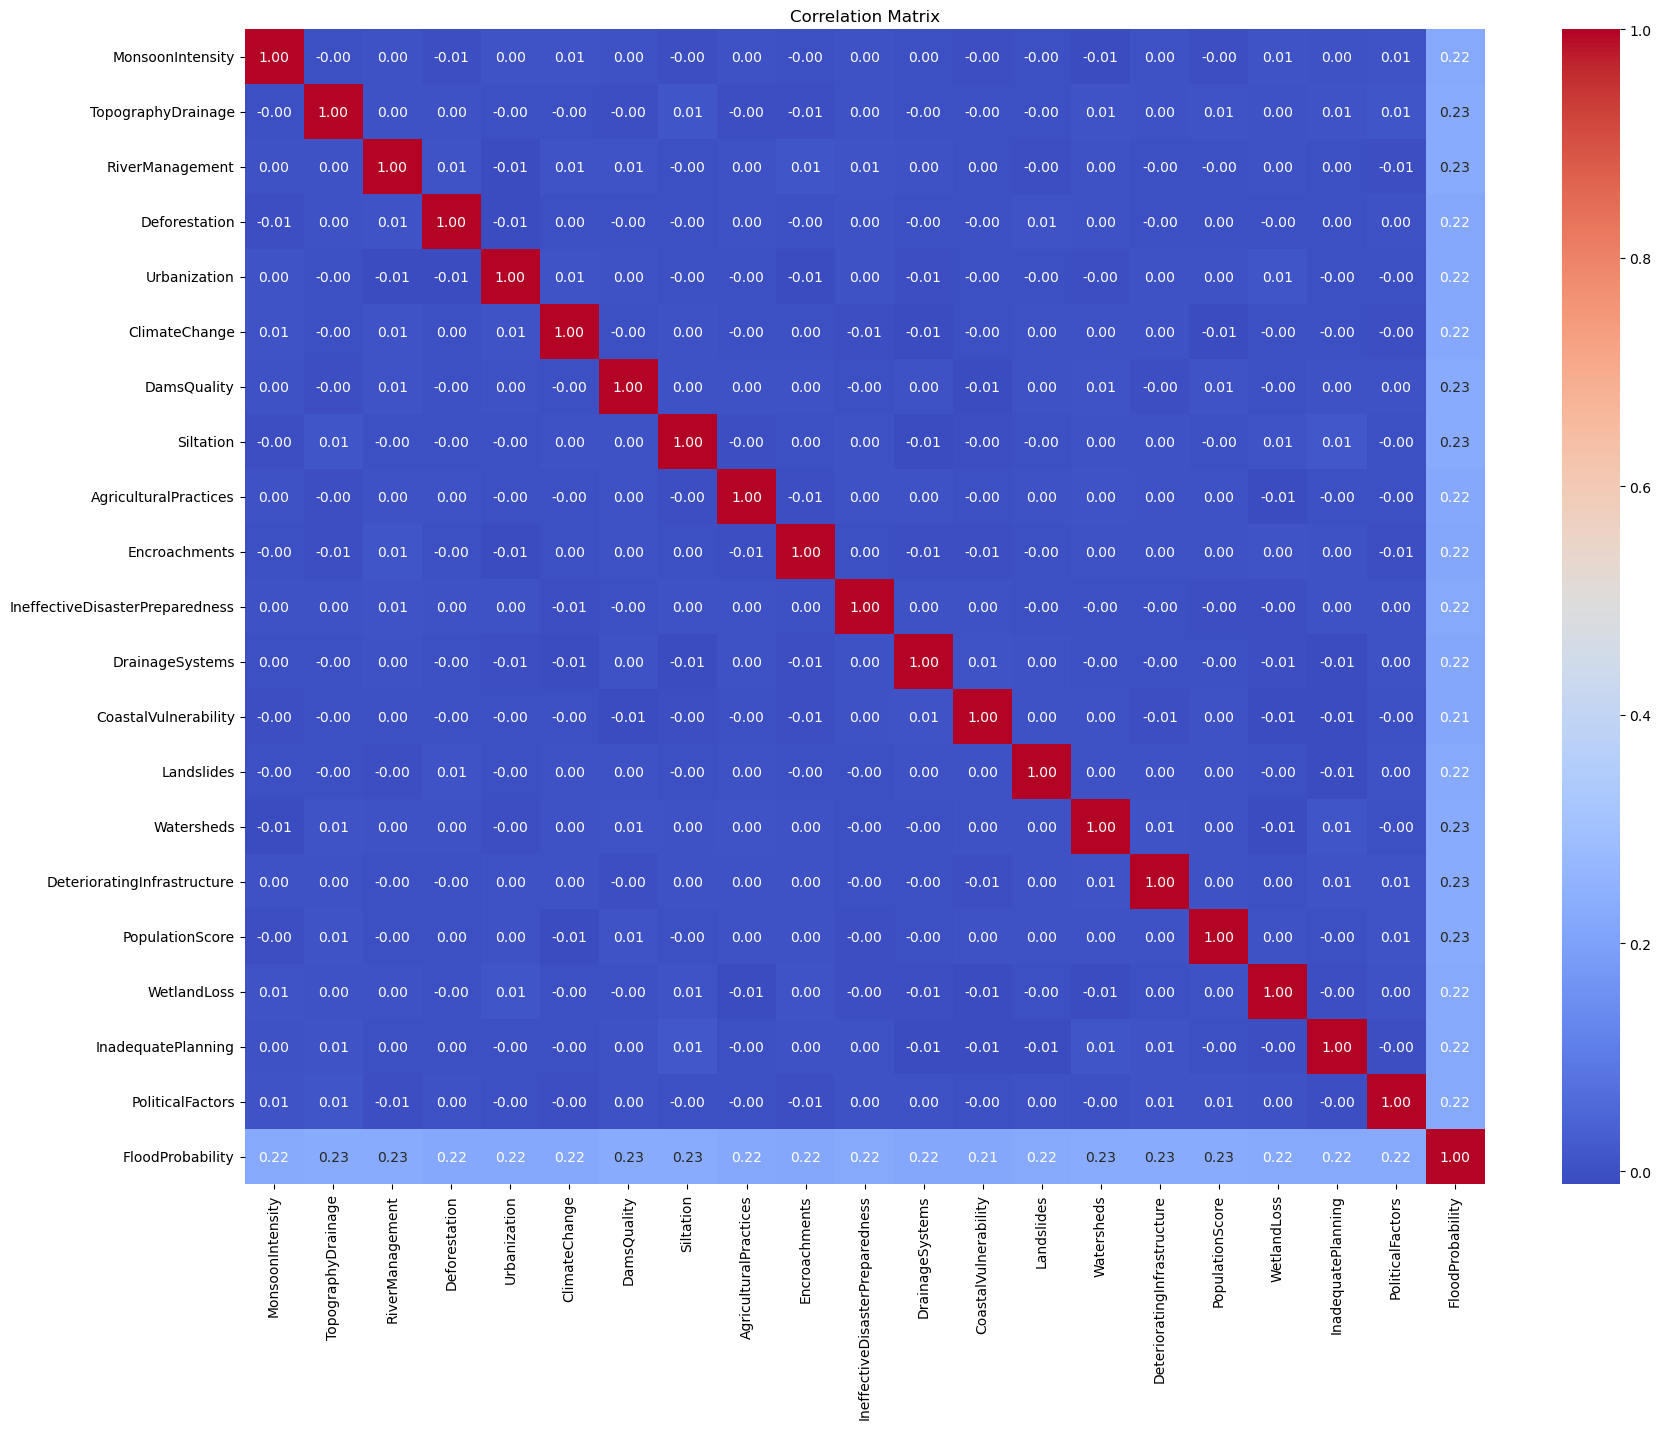

Top 10 features correlated with FloodProbability:
TopographyDrainage                 0.229279
DeterioratingInfrastructure        0.228484
RiverManagement                    0.228265
Watersheds                         0.228194
DamsQuality                        0.226557
PopulationScore                    0.226325
Siltation                          0.226004
PoliticalFactors                   0.224608
IneffectiveDisasterPreparedness    0.224593
MonsoonIntensity                   0.223357
Name: FloodProbability, dtype: float64


In [26]:
# Step 4: Exploratory Data Analysis (EDA)
# Ploting correlation matrix
plt.figure(figsize=(20, 15))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Top 10 features most correlated with FloodProbability
corr_with_target = corr['FloodProbability'].sort_values(ascending=False)
top_10_features = corr_with_target[1:11].index.tolist() 
print("Top 10 features correlated with FloodProbability:")
print(corr_with_target[1:11])

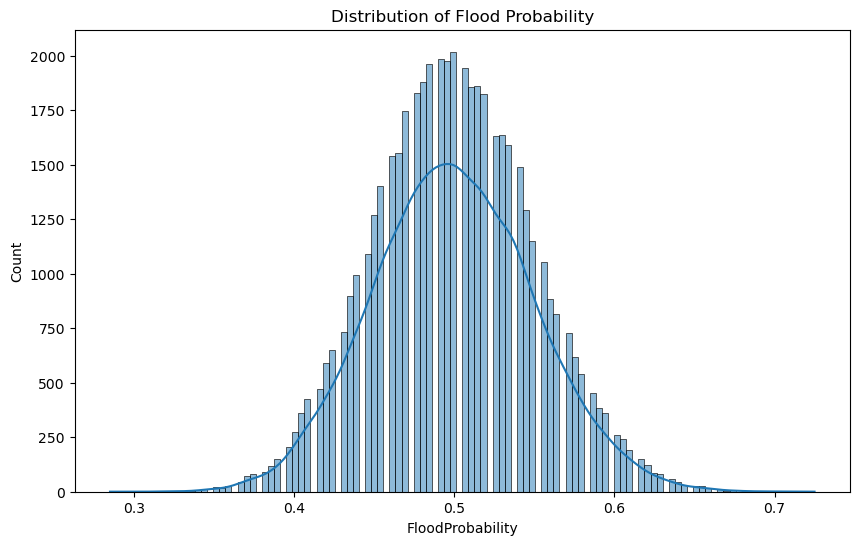

In [22]:
# Ploting distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['FloodProbability'], kde=True)
plt.title('Distribution of Flood Probability')
plt.show()

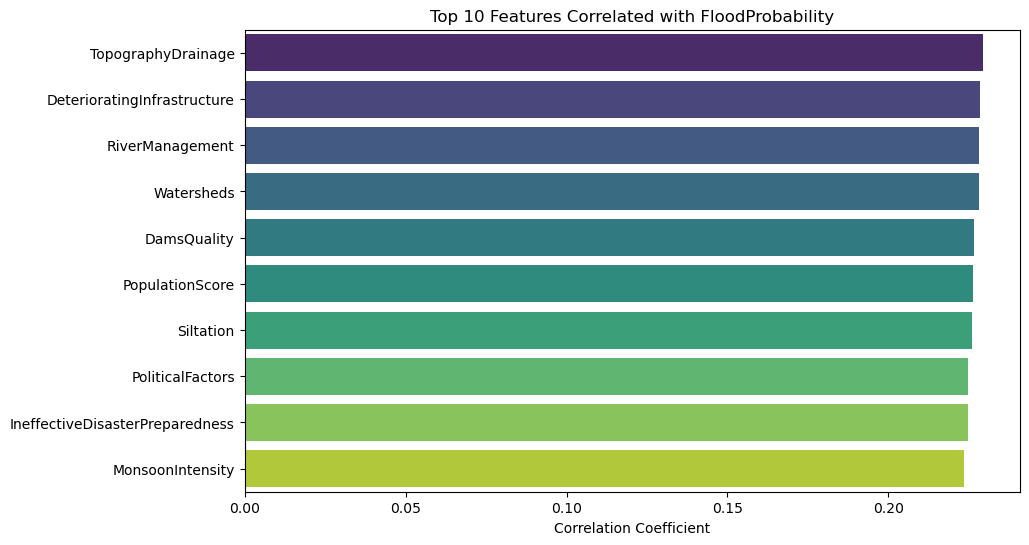

In [28]:
# Visualization of top 10 features most correlated with FloodProbability 
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target[1:11].values, y=top_10_features, palette='viridis')
plt.title('Top 10 Features Correlated with FloodProbability')
plt.xlabel('Correlation Coefficient')
plt.show()

Linear Regression
Linear Regression Metrics:
MSE: 0.0000
RMSE: 0.0038
MAE: 0.0022
R-squared: 0.9943
Training Time: 0.20 seconds
Prediction Time: 0.02 seconds
Overall Execution Time: 0.22 seconds
Statsmodels OLS Summary:
                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 3.632e+05
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        18:32:24   Log-Likelihood:             1.6717e+05
No. Observations:               40000   AIC:                        -3.343e+05
Df Residuals:                   39979   BIC:                        -3.341e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                

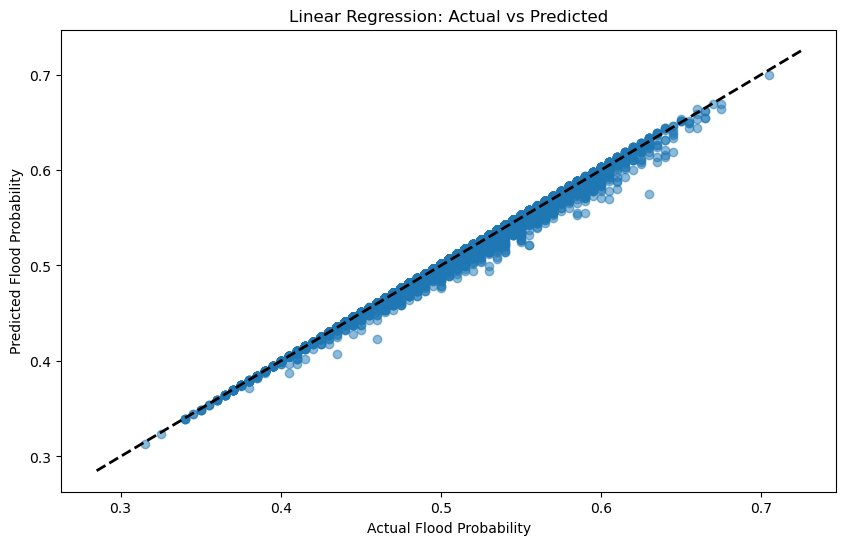

In [30]:
# Step 5: Using Linear Regresion model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time
import numpy as np 
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

print("Linear Regression")
lr = LinearRegression()

# Start timer for training
start_training_time_lr = time.time()
lr.fit(X_train, y_train)
end_training_time_lr = time.time()
training_time_lr = end_training_time_lr - start_training_time_lr

# Start timer for prediction 
start_prediction_time_lr = time.time()
y_pred_lr = lr.predict(X_test)
end_prediction_time_lr = time.time()
prediction_time_lr = end_prediction_time_lr - start_prediction_time_lr

# Overall execution time (training + prediction)
overall_execution_time_lr = training_time_lr + prediction_time_lr


mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Metrics:")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")
print(f"R-squared: {r2_lr:.4f}")
print(f"Training Time: {training_time_lr:.2f} seconds") 
print(f"Prediction Time: {prediction_time_lr:.2f} seconds") 
print(f"Overall Execution Time: {overall_execution_time_lr:.2f} seconds") 

X_train_sm = sm.add_constant(X_train)
lr_sm = sm.OLS(y_train, X_train_sm).fit()
print("Statsmodels OLS Summary:")
print(lr_sm.summary())

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Flood Probability')
plt.ylabel('Predicted Flood Probability')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

Random Forest Classification
Accuracy: 0.8940
Training Time: 16.27 seconds
Prediction Time: 0.83 seconds
Total Execution Time: 17.09 seconds
Confusion Matrix:
[[4897  363]
 [ 697 4043]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5260
           1       0.92      0.85      0.88      4740

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



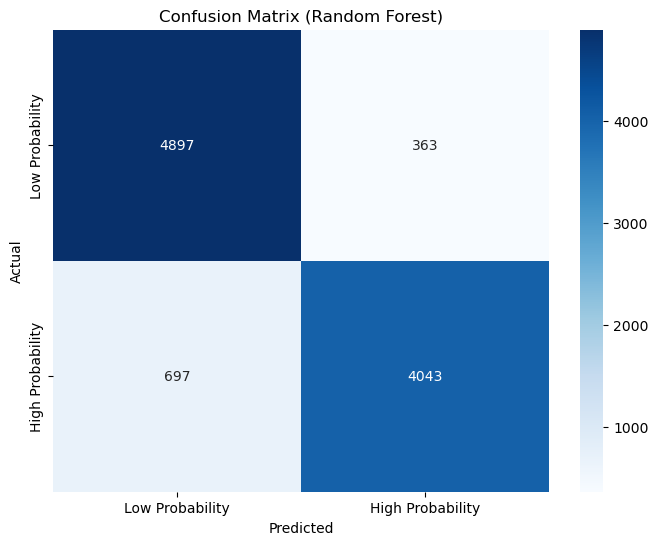

In [32]:
# Step 6: Using Random Forest Classification
print("Random Forest Classification")
threshold = y.median()
y_train_class = (y_train > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
start_time_train = time.time()  
rf_classifier.fit(X_train, y_train_class)
end_time_train = time.time()  
training_time_rf = end_time_train - start_time_train  

start_time_pred = time.time()  
y_pred_class = rf_classifier.predict(X_test)
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
end_time_pred = time.time()  
prediction_time_rf = end_time_pred - start_time_pred  

total_time_rf = training_time_rf + prediction_time_rf

accuracy_rf = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Training Time: {training_time_rf:.2f} seconds")
print(f"Prediction Time: {prediction_time_rf:.2f} seconds")
print(f"Total Execution Time: {total_time_rf:.2f} seconds")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Probability', 'High Probability'],
            yticklabels=['Low Probability', 'High Probability'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
print("Class distribution:", y_train_class.value_counts())

Class distribution: FloodProbability
0    21245
1    18755
Name: count, dtype: int64


In [36]:
# Step 7:Using CPU Multiprocessing implementation
from joblib import Parallel, delayed
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
import time

def train_rf(X_train, y_train, X_test, y_test):
    start_train = time.time()  
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    end_train = time.time()  
    
    start_pred = time.time()  
    y_pred = model.predict(X_test)
    end_pred = time.time()  
    
    training_time = end_train - start_train
    prediction_time = end_pred - start_pred
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'training_time': training_time,
        'prediction_time': prediction_time 
    }

print("CPU Multiprocessing")
num_cores = multiprocessing.cpu_count()
print(f"CPU Cores available: {num_cores}")

start_time = time.time()
results = Parallel(n_jobs=num_cores)(
    delayed(train_rf)(X_train, y_train_class, X_test, y_test_class) 
    for _ in range(num_cores)
) 
cpu_time = time.time() - start_time

accuracies = [result['accuracy'] for result in results]
training_times = [result['training_time'] for result in results]
prediction_times = [result['prediction_time'] for result in results]

cpu_accuracy = np.mean(accuracies)
avg_training_time = np.mean(training_times)
avg_prediction_time = np.mean(prediction_times)

print(f"Average Accuracy: {cpu_accuracy:.4f}")
print(f"Average Training Time per model: {avg_training_time:.4f} seconds")
print(f"Average Prediction Time per model: {avg_prediction_time:.4f} seconds")
print(f"Total Parallel Execution Time: {cpu_time:.2f} seconds")
print(f"Total CPU Utilization: {avg_training_time * num_cores:.2f} core-seconds")

CPU Multiprocessing
CPU Cores available: 16
Average Accuracy: 0.8940
Average Training Time per model: 40.6936 seconds
Average Prediction Time per model: 1.2142 seconds
Total Parallel Execution Time: 61.66 seconds
Total CPU Utilization: 651.10 core-seconds


In [38]:
# Step 8: Using Spark implementation
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as F
import time

def run_spark_implementation(df, threshold):
    print("Spark Implementation")

    # Configuring Spark with more memory and proper settings
    spark = None
    try:
        spark = SparkSession.builder \
            .appName("FloodPrediction") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "4g") \
            .config("spark.memory.offHeap.enabled", "true") \
            .config("spark.memory.offHeap.size", "2g") \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .getOrCreate()

        # Converting pandas DataFrame to Spark DataFrame
        print("Converting pandas DataFrame to Spark DataFrame...")
        spark_df = spark.createDataFrame(df)
        
        # Verifying all feature columns exist and are numeric too
        print("Verifying feature columns...")
        feature_cols = [col for col in df.columns if col != 'FloodProbability']
        missing_cols = [col for col in feature_cols if col not in spark_df.columns]
        if missing_cols:
            raise ValueError(f"Columns missing in Spark DataFrame: {missing_cols}")

        # Creating feature vector
        print("Creating feature vector...")
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        spark_df = assembler.transform(spark_df)
        
        # Creating binary label column
        print("Creating label column...")
        spark_df = spark_df.withColumn("label", 
                                     (F.col("FloodProbability") > float(threshold)).cast("integer"))
        
        # Checking for any null values
        print("Checking for null values...")
        null_counts = spark_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) 
                                     for c in ["features", "label"]])
        nulls = null_counts.collect()[0]
        if nulls["features"] > 0 or nulls["label"] > 0:
            raise ValueError(f"Null values detected - features: {nulls['features']}, label: {nulls['label']}")

        # Splitting data for train-test 
        print("Splitting data...")
        train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)
        
        # Training Random Forest for spark
        print("Training Random Forest...")
        spark_rf = SparkRF(featuresCol="features",
                         labelCol="label",
                         numTrees=100,
                         maxDepth=5,  
                         seed=42,
                         subsamplingRate=0.8)  
        
        # Measuring training time
        train_start = time.time()
        spark_model = spark_rf.fit(train_df)
        train_time = time.time() - train_start
        
        # 8. Making predictions
        print("Making predictions...")
        predict_start = time.time()
        spark_predictions = spark_model.transform(test_df)
        predict_time = time.time() - predict_start
        
        # 9. Evaluating model
        print("Evaluating model...")
        evaluator = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="accuracy"
        )
        spark_accuracy = evaluator.evaluate(spark_predictions)
        total_time = train_time + predict_time
        
        print(f"Spark Results:")
        print(f"Accuracy: {spark_accuracy:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
        print(f"Prediction Time: {predict_time:.2f} seconds")
        print(f"Total Execution Time: {total_time:.2f} seconds")
        
        return spark_accuracy, train_time, predict_time
        
    except Exception as e:
        print(f"nERROR in Spark implementation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None
        
    finally:
        if spark:
            print("Stopping Spark session...")
            spark.stop()

# Running the Spark implementation
spark_accuracy, spark_train_time, spark_predict_time = run_spark_implementation(df, threshold)

Spark Implementation
Converting pandas DataFrame to Spark DataFrame...
Verifying feature columns...
Creating feature vector...
Creating label column...
Checking for null values...
Splitting data...
Training Random Forest...
Making predictions...
Evaluating model...
Spark Results:
Accuracy: 0.7939
Training Time: 32.57 seconds
Prediction Time: 0.30 seconds
Total Execution Time: 32.87 seconds
Stopping Spark session...
